#### Part2. 심화학습 - AI 사례 실습 
    chp11 - 비데, 정수기 렌탈고객 해지 예측 : (3) Preprocessing, Modeling 

In [1]:
# 환경설정 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time 
import math 
from tqdm import tqdm
from datetime import datetime 
np.random.seed(42)

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   ## 시각화 음수 표현 가능 

In [2]:
train_data = pd.read_parquet("data/train_data.parquet", engine='pyarrow')
test_data = pd.read_parquet("data/test_data.parquet", engine='pyarrow')

train_data.shape, test_data.shape

((55000, 30), (5000, 30))

--- 
### Preprocessing
1) numeric cols :  표준화 > 이상치 제거 > 정규화  (**단 데이터의 실제 이상치 여부 판단이 어려워, 이상치 제거는 생략하고 진행함*) 
2) categorical cols :  Label encoding > One-hot encoding
3) 최종변수 선택  

In [3]:
#수치형 변수들 
numbers = ['int64', 'float64']
num_cols = train_data.select_dtypes(numbers).columns
num_cols

Index(['bidet_cnt', 'w_disp_cnt', '3m_avg_bill_amt', '3m_bidet_avg_amt',
       '3m_w_disp_avg_amt', 'voc_cnt_가입', 'voc_cnt_변경/조회', 'voc_cnt_업무협조',
       'voc_cnt_이용', 'voc_cnt_청구 수/미납', 'voc_cnt_해지', 'day_cnt_가입',
       'day_cnt_변경/조회', 'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납',
       'day_cnt_해지', 'join_period', 'bidet_teperd', 'w_disp_teperd',
       'w_disp_erperd', 'bidet_erperd'],
      dtype='object')

In [4]:
# 표준화 : 평균 = 0, 표준편차 = 1 
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
train_data[num_cols] = standardScaler.fit_transform(train_data[num_cols])
test_data[num_cols] = standardScaler.transform(test_data[num_cols])

train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd
count,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,...,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04,5.500000e+04
mean,-2.712981e-18,-5.083610e-17,2.170385e-17,-2.842171e-18,-4.844610e-18,-1.446923e-17,7.893484e-17,3.035955e-18,3.501038e-17,-1.098112e-17,...,4.825231e-17,1.653627e-17,-4.805853e-17,7.880565e-18,-1.627789e-17,-7.137725e-17,3.225864e-16,-3.214237e-16,-5.109448e-17,-1.421085e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-3.906204e-02,-6.483763e-01,-3.565643e-01,-8.977446e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-1.149802e+00,-6.458014e+00,-6.558596e+00,-1.940832e+00,-1.500677e+00
25%,-2.401956e-02,-6.483763e-01,-2.134368e-01,-6.026667e-01,-1.049899e-01,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-6.869425e-01,1.982746e-01,1.936772e-01,-8.867821e-01,-6.431238e-01
50%,-2.401956e-02,2.310707e-01,-1.084393e-01,-8.702069e-02,-2.262107e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,-3.100954e-01,1.982746e-01,1.936772e-01,6.942933e-01,-3.271832e-01
75%,-8.977078e-03,2.310707e-01,5.265599e-02,3.555961e-01,1.585976e-02,-3.548972e-01,-3.884408e-01,-3.752426e-01,-3.110110e-01,-4.552106e-01,...,-4.497047e-01,-4.898579e-01,-3.244886e-01,-4.727622e-01,-5.261423e-01,4.077088e-01,1.982746e-01,1.936772e-01,8.825166e-01,3.498324e-01
max,7.633160e+01,1.092825e+02,2.122352e+02,7.978902e+01,1.531834e+02,1.603414e+01,1.063694e+02,1.147525e+02,3.478769e+01,1.718309e+01,...,2.410769e+01,2.708659e+01,3.000389e+01,1.458585e+01,1.104128e+01,4.045614e+00,1.982746e-01,1.936772e-01,8.825166e-01,1.748998e+00


In [5]:
# 정규화 : 0~1 값의 분포 
from sklearn.preprocessing import MinMaxScaler
minmaxScaler = MinMaxScaler()

train_data[num_cols] = minmaxScaler.fit_transform(train_data[num_cols])
test_data[num_cols] = minmaxScaler.transform(test_data[num_cols])

train_data[num_cols].describe()

,bidet_cnt,w_disp_cnt,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,voc_cnt_가입,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_청구 수/미납,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd
count,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,...,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000,55000.000000
mean,0.000511,0.005898,0.001677,0.011126,0.000685,0.021655,0.003639,0.003259,0.008861,0.025808,...,0.018312,0.017764,0.010699,0.031395,0.045485,0.221311,0.970212,0.971317,0.687422,0.461793
std,0.013094,0.009097,0.004704,0.012394,0.006524,0.061017,0.009367,0.008686,0.028491,0.056695,...,0.040721,0.036263,0.032973,0.066408,0.086450,0.192479,0.150235,0.148100,0.354193,0.307726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000197,0.000000,0.000673,0.003657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089090,1.000000,1.000000,0.373333,0.263889
50%,0.000197,0.008000,0.001167,0.010048,0.000537,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.161625,1.000000,1.000000,0.933333,0.361111
75%,0.000394,0.008000,0.001925,0.015533,0.000788,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.299786,1.000000,1.000000,1.000000,0.569444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# 카테고리 변수들 
le_columns = train_data.select_dtypes('object').columns
le_columns

Index(['status', 'sex_cd', 'w_disp_yn', 'bidet_yn', 'comb_prod_yn',
       'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn'],
      dtype='object')

In [7]:
# Label encoding 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in le_columns: 
    le.fit(train_data[column])
    train_data[column] = le.transform(train_data[column])

    ## train_data와 test_data의 컬럼이 다를 경우 고려 
    for label in np.unique(test_data[column]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)

    test_data[column] = le.transform(test_data[column])

le.classes_ 

array(['N', 'Y'], dtype=object)

In [8]:
train_data.head(2)

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd
0,1,0.000197,0.0,0,1,1,1,1,1,1,...,0.0,0.0,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,0,0.000394,0.0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889


In [9]:
## status : Y(유지)=1, N(해지)=0 
## 관심있는 것은 "해지"이므로, Y/N를 반전 시킨다.
train_data['status'] = train_data['status'].apply(lambda x : 1 if x== 0 else 0)
test_data['status'] = test_data['status'].apply(lambda x : 1 if x== 0 else 0)

train_data.head(2)

,status,bidet_cnt,w_disp_cnt,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,...,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_청구 수/미납,day_cnt_해지,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd
0,0,0.000197,0.0,0,1,1,1,1,1,1,...,0.0,0.0,0.0,0.142857,0.000000,0.146260,1.0,1.0,0.373333,0.305556
1,1,0.000394,0.0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.166667,0.293354,1.0,1.0,1.000000,0.388889


In [10]:
# one-hot encoding
## 먼저 0,1 이외의 값을 가진 컬럼 확인 
for column in le_columns:
    print(train_data[column].value_counts())

status
0    31806
1    23194
Name: count, dtype: int64
sex_cd
1    28486
0    25178
2     1336
Name: count, dtype: int64
w_disp_yn
1    32474
0    22526
Name: count, dtype: int64
bidet_yn
1    44657
0    10343
Name: count, dtype: int64
comb_prod_yn
1    41462
0    13538
Name: count, dtype: int64
bidet_comb_yn
1    33075
0    21925
Name: count, dtype: int64
w_disp_comb_yn
1    38924
0    16076
Name: count, dtype: int64
npay_yn
0    44920
1    10080
Name: count, dtype: int64


In [11]:
## sex_cd만 유일하게 2값이 있음 --> sex_cd외 다른 변수들은 원-핫 코딩 불필요
oh_columns=['sex_cd']
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False,drop='if_binary')       ## sparse=True/False : '희소행렬/Numpy행렬'로 반환, ## drop='if_binary : 이진변수는 원핫코딩 제외(한 컬럼에 0,1을 담는다)
train_onehot=enc.fit_transform(train_data[oh_columns])
test_onehot=enc.transform(test_data[oh_columns])

train_onehot

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [12]:
## 원핫코딩 데이터 합치고, 불필요한 컬럼은 제거 
train_data_OH=pd.concat([train_data,pd.DataFrame(train_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)
test_data_OH=pd.concat([test_data,pd.DataFrame(test_onehot,columns=enc.get_feature_names_out(oh_columns))],axis=1)

train_data_OH.drop(oh_columns,axis=1,inplace=True)
test_data_OH.drop(oh_columns,axis=1,inplace=True)

train_data=train_data_OH
test_data=test_data_OH

train_data

,status,bidet_cnt,w_disp_cnt,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,npay_yn,3m_avg_bill_amt,...,day_cnt_청구 수/미납,day_cnt_해지,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd,sex_cd_0,sex_cd_1,sex_cd_2
0,0,0.000197,0.000,1,1,1,1,1,1,0.002176,...,0.142857,0.000000,0.146260,1.000000,1.0,0.373333,0.305556,1.0,0.0,0.0
1,1,0.000394,0.000,0,1,0,0,0,0,0.000672,...,0.000000,0.166667,0.293354,1.000000,1.0,1.000000,0.388889,0.0,1.0,0.0
2,1,0.000197,0.008,1,0,1,1,1,0,0.000561,...,0.000000,0.000000,0.134231,1.000000,1.0,0.493333,1.000000,0.0,1.0,0.0
3,0,0.000788,0.008,1,1,1,1,1,1,0.001271,...,0.000000,0.000000,0.474988,1.000000,1.0,0.973333,0.319444,1.0,0.0,0.0
4,1,0.000197,0.008,1,1,1,1,1,0,0.001780,...,0.000000,0.166667,0.207837,1.000000,1.0,0.133333,0.166667,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54995,1,0.000000,0.008,1,0,1,0,1,1,0.000771,...,0.000000,0.000000,0.650667,1.000000,1.0,0.920000,1.000000,0.0,1.0,0.0
54996,0,0.000000,0.008,1,0,1,0,1,0,0.000611,...,0.000000,0.166667,0.331467,0.973684,1.0,0.506667,1.000000,1.0,0.0,0.0
54997,0,0.000788,0.008,0,1,0,0,0,0,0.000494,...,0.000000,0.000000,0.049905,1.000000,1.0,1.000000,0.222222,1.0,0.0,0.0
54998,0,0.000591,0.008,0,1,0,0,0,0,0.000695,...,0.142857,0.166667,0.045855,1.000000,1.0,1.000000,0.208333,0.0,1.0,0.0


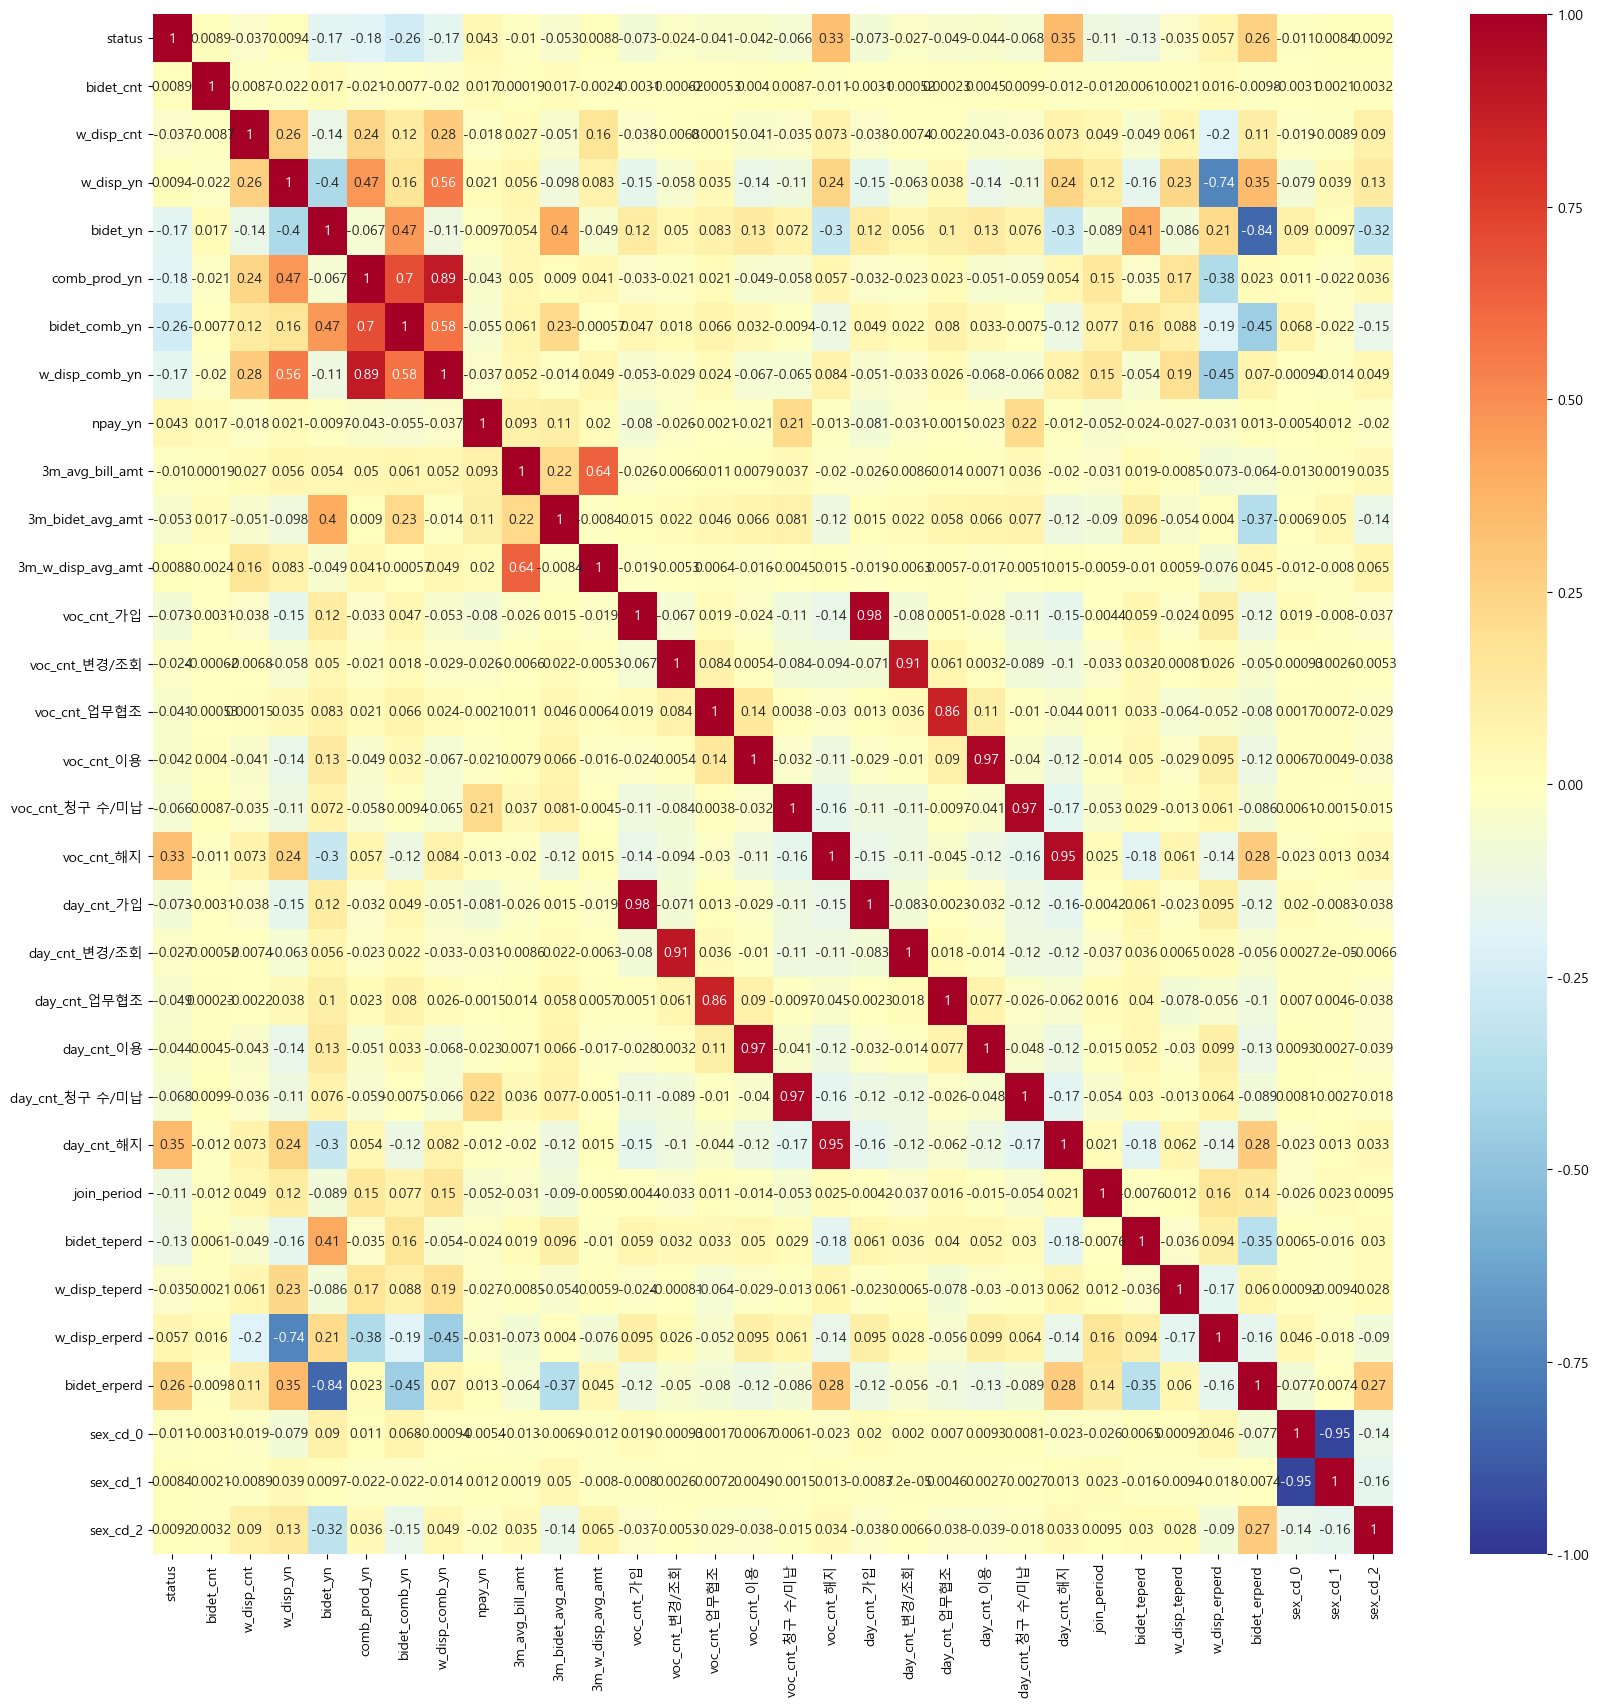

In [13]:
# VIF 제거 
plt.figure(figsize=(20,20))
sns.heatmap(data=train_data.corr(), annot=True, cmap='RdYlBu_r', vmin=-1, vmax=1)   ## vmin, vmax : 최소~최대일때의 색상 
plt.show()

In [14]:
## 다중공선성 확인 
# VIF를 확인하기 위한 패키지 불러오기
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF계산 결과를 데이터프레임에 담기
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(train_data.values, i) for i in tqdm(range(train_data.shape[1]))]
vif['Feature'] = train_data.columns

# VIF값 순서대로 내림차순 정렬하기
vif = vif.sort_values(by="VIF_Factor", ascending=False).reset_index().drop(columns='index')
vif

100%|██████████| 32/32 [00:03<00:00,  8.10it/s]


,VIF_Factor,Feature
0,80.575735,sex_cd_1
1,71.338545,sex_cd_0
2,30.152586,day_cnt_가입
3,29.990095,voc_cnt_가입
4,19.843187,voc_cnt_이용
5,19.705031,day_cnt_이용
6,17.886209,day_cnt_청구 수/미납
7,17.683989,voc_cnt_청구 수/미납
8,10.156465,day_cnt_해지
9,9.917503,voc_cnt_해지


In [15]:
'''
VIF가 높은 변수 중, 실제 비즈니스 행태를 고려하여 삭제대상 선정 
(1) sex_cd_1 : 원핫 인코딩으로 생성된 가변수 
(2) voc_cnt_가입, voc_cnt_이용, voc_cnt_청구 수/미납, voc_cnt_해지 : day_cnt_**이 있으므로 삭제 
(3) comb_prod_yn : 결합상품 여부는 삭제할 경우, 결합/단독 상품 이용에 따른 특성이 사라지므로 유지 
'''
del_cols=['sex_cd_1','voc_cnt_가입','voc_cnt_이용','voc_cnt_청구 수/미납','voc_cnt_해지']

train_data=train_data.drop(del_cols,axis=1)
test_data=test_data.drop(del_cols,axis=1)

train_data.columns

Index(['status', 'bidet_cnt', 'w_disp_cnt', 'w_disp_yn', 'bidet_yn',
       'comb_prod_yn', 'bidet_comb_yn', 'w_disp_comb_yn', 'npay_yn',
       '3m_avg_bill_amt', '3m_bidet_avg_amt', '3m_w_disp_avg_amt',
       'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'day_cnt_가입', 'day_cnt_변경/조회',
       'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_청구 수/미납', 'day_cnt_해지',
       'join_period', 'bidet_teperd', 'w_disp_teperd', 'w_disp_erperd',
       'bidet_erperd', 'sex_cd_0', 'sex_cd_2'],
      dtype='object')

--- 
#### Modeling and Evaluation 
1) 데이터 분할 
2) 모델 생성 
3) 학습 및 평가 

In [16]:
# data split 
from sklearn.model_selection import train_test_split

y = train_data['status']
X = train_data.drop('status', axis=1)

x_train, x_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=42)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(41250, 26) (13750, 26) (41250,) (13750,)


In [19]:
## test data
y_test = test_data['status']
x_test = test_data.drop('status', axis=1)

print(x_test.shape, y_test.shape)

(5000, 26) (5000,)


In [23]:
## funtion : chart for models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

result = pd.DataFrame([], columns = ['acc', 'recall', 'precision', 'F1-score'])

'''
parameters 
- model_name : 모델명(str)
- pred : 예측값 
- actual : 실제값(y_test)
'''

def result_view(model_name, pred, actual): 
    acc = round(accuracy_score(actual, pred),3)
    precision = round(precision_score(actual, pred),3)
    recall = round(recall_score(actual, pred),3)
    F1 = round(f1_score(actual, pred),3)

    result.loc[model_name] = (acc, recall, precision, F1)
    result.sort_values(by='acc', inplace=True, ascending=False)
    print(result)

    plt.figure(figsize=(7,4))
    for idx in result.index:
        x_values = result.columns  # x축 지점의 값들
        y_values = result.loc[idx] # y축 지점의 값들
        plt.plot(x_values, y_values)# line 그래프 그리기
        plt.annotate(text=round(result.loc[idx,'acc'],3), xy=(0,result.loc[idx,'acc']),xytext=(0,result.loc[idx,'acc']),ha='center',fontsize=10)        
        plt.annotate(text=round(result.loc[idx,'recall'],3), xy=(1,result.loc[idx,'recall']),xytext=(1,result.loc[idx,'recall']),ha='center',fontsize=10)
        plt.annotate(text=round(result.loc[idx,'precision'],3), xy=(2,result.loc[idx,'precision']),xytext=(2,result.loc[idx,'precision']),ha='center',fontsize=10,)
        plt.annotate(text=round(result.loc[idx,'F1-score'],3), xy=(3,result.loc[idx,'F1-score']),xytext=(3,result.loc[idx,'F1-score']),ha='center',fontsize=10)

    plt.legend(result.index,loc=4) # 범례의 위치        
    plt.show()   

                      acc  recall  precision  F1-score
LogisticRegression  0.735   0.585      0.721     0.646


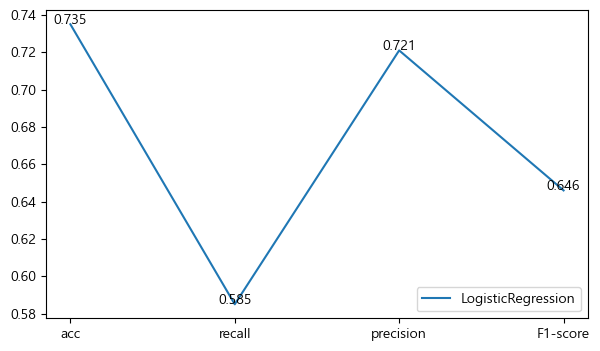

In [24]:
# modeling 1 : LogisticRegression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(x_train, y_train)

pred_lr = model_lr.predict(x_test)
result_view('LogisticRegression', pred_lr, y_test)

                      acc  recall  precision  F1-score
LogisticRegression  0.735   0.585      0.721     0.646
KNN                 0.714   0.603      0.673     0.636


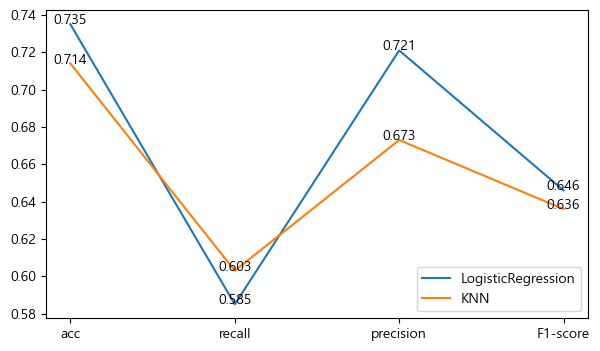

In [25]:
# modeling 2 : KNN
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)

pred_knn = model_knn.predict(x_test)
result_view('KNN', pred_knn, y_test)

                      acc  recall  precision  F1-score
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


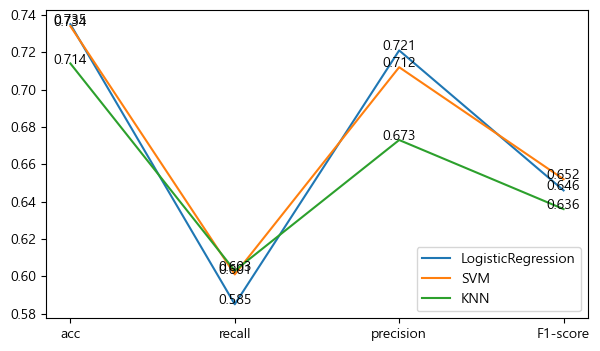

In [26]:
# modeling 3 : SVM 
from sklearn.svm import SVC
model_svc = SVC(random_state=42)
model_svc.fit(x_train, y_train)

pred_svm = model_svc.predict(x_test)
result_view('SVM', pred_svm, y_test)

                      acc  recall  precision  F1-score
DecisionTree        0.748   0.625      0.727     0.672
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


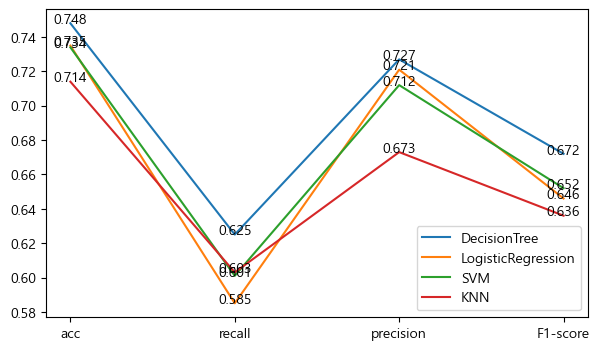

In [28]:
# modeling 4 : DecisionTree
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(max_depth=5, 
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  max_features=None, 
                                  max_leaf_nodes=None, 
                                  random_state=42 )

model_dt.fit(x_train, y_train)
pred_dt = model_dt.predict(x_test)
result_view('DecisionTree', pred_dt, y_test)

                      acc  recall  precision  F1-score
RandomForest        0.758   0.640      0.740     0.686
DecisionTree        0.748   0.625      0.727     0.672
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


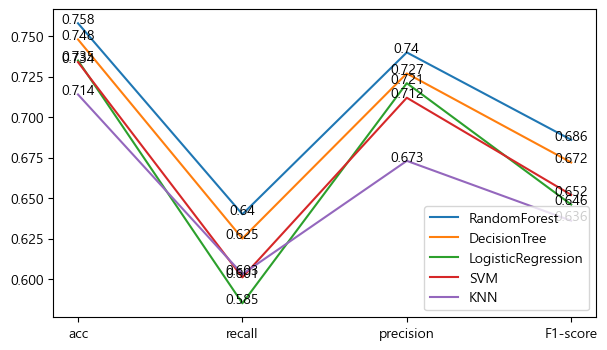

In [30]:
# modeling 5 : RandomForest 
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                  min_samples_split=2, 
                                  min_samples_leaf=1, 
                                  max_depth=None, 
                                  max_features=None, 
                                  max_leaf_nodes=None, 
                                  random_state=42
                                   )
model_rf.fit(x_train, y_train)
pred_rf = model_rf.predict(x_test)
result_view('RandomForest', pred_rf, y_test)

#### 참고
- XGBoost : 랜덤포레스트와 비슷하나, 잘못 예측된 데이터에 가중치를 부여하여 학습 
- CatBoost : 트리를 대칭적으로 구성하여 빠른 속도, Overfitting 보완 알고리즘 포함 (category 변수가 많을때 좋은 성능)

In [33]:
# modeling 6 : XGBoot 
import xgboost as xgb
model_xgb = xgb.XGBClassifier(n_estimators = 500, n_jobs = -1, 
                              learning_rate = 0.1, 
                              random_state = 42
                              )

start=time.time()
eval_set = [(x_valid, y_valid)]

# logloss가 10회 개선되지 않으면 중단하도록 early stopping 설정하기
model_xgb.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
(time.time()-start)/60

[0]	validation_0-logloss:0.65300
[1]	validation_0-logloss:0.63054
[2]	validation_0-logloss:0.61182
[3]	validation_0-logloss:0.59645
[4]	validation_0-logloss:0.58355
[5]	validation_0-logloss:0.57224
[6]	validation_0-logloss:0.56283
[7]	validation_0-logloss:0.55468
[8]	validation_0-logloss:0.54771
[9]	validation_0-logloss:0.54147
[10]	validation_0-logloss:0.53641
[11]	validation_0-logloss:0.53190
[12]	validation_0-logloss:0.52794
[13]	validation_0-logloss:0.52430
[14]	validation_0-logloss:0.52104
[15]	validation_0-logloss:0.51818
[16]	validation_0-logloss:0.51570
[17]	validation_0-logloss:0.51346
[18]	validation_0-logloss:0.51133
[19]	validation_0-logloss:0.50957
[20]	validation_0-logloss:0.50806
[21]	validation_0-logloss:0.50676
[22]	validation_0-logloss:0.50537
[23]	validation_0-logloss:0.50418
[24]	validation_0-logloss:0.50324
[25]	validation_0-logloss:0.50237
[26]	validation_0-logloss:0.50132
[27]	validation_0-logloss:0.50026
[28]	validation_0-logloss:0.49944
[29]	validation_0-loglos

0.017266452312469482

                      acc  recall  precision  F1-score
XGBoot              0.763   0.640      0.750     0.690
RandomForest        0.758   0.640      0.740     0.686
DecisionTree        0.748   0.625      0.727     0.672
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


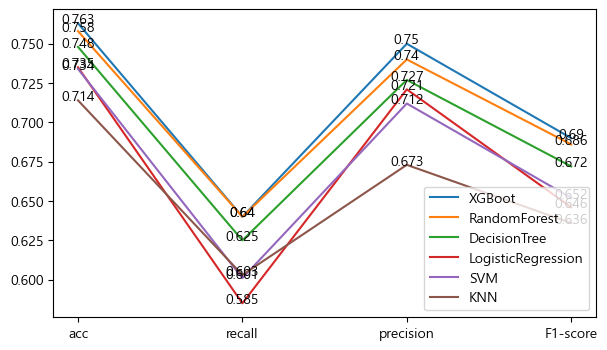

In [34]:
pred_xgb = model_xgb.predict(x_test)
result_view('XGBoot', pred_xgb, y_test)

In [41]:
# modeling 7 : Catboost 
from catboost import CatBoostClassifier, Pool  
model_cat = CatBoostClassifier(iterations = 2000, learning_rate = 0.03, random_state=42)

start=time.time()

# Pool 함수로 데이터셋 지정하기. 반드시 label을 지정해 주어야 함
train_dataset = Pool(data=x_train,label=y_train) #feature와 label 지정하기
eval_dataset = Pool(data=x_valid,label=y_valid) #feature와 label 지정하기

model_cat.fit(train_dataset, eval_set=eval_dataset,early_stopping_rounds=30)

(time.time()-start)/60

0:	learn: 0.6823904	test: 0.6825180	best: 0.6825180 (0)	total: 9.73ms	remaining: 19.5s
1:	learn: 0.6738911	test: 0.6740801	best: 0.6740801 (1)	total: 18ms	remaining: 18s
2:	learn: 0.6647456	test: 0.6650035	best: 0.6650035 (2)	total: 26.3ms	remaining: 17.5s
3:	learn: 0.6562007	test: 0.6565396	best: 0.6565396 (3)	total: 34.3ms	remaining: 17.1s
4:	learn: 0.6477520	test: 0.6481132	best: 0.6481132 (4)	total: 43.2ms	remaining: 17.2s
5:	learn: 0.6399856	test: 0.6404752	best: 0.6404752 (5)	total: 51.8ms	remaining: 17.2s
6:	learn: 0.6330524	test: 0.6335702	best: 0.6335702 (6)	total: 60.7ms	remaining: 17.3s
7:	learn: 0.6262898	test: 0.6267888	best: 0.6267888 (7)	total: 68.1ms	remaining: 17s
8:	learn: 0.6206589	test: 0.6211866	best: 0.6211866 (8)	total: 76.6ms	remaining: 16.9s
9:	learn: 0.6153121	test: 0.6158767	best: 0.6158767 (9)	total: 83.8ms	remaining: 16.7s
10:	learn: 0.6101391	test: 0.6107512	best: 0.6107512 (10)	total: 92.1ms	remaining: 16.6s
11:	learn: 0.6052083	test: 0.6058381	best: 0.60

0.17678794463475545

                      acc  recall  precision  F1-score
CatBoost            0.764   0.646      0.750     0.694
XGBoot              0.763   0.640      0.750     0.690
RandomForest        0.758   0.640      0.740     0.686
DecisionTree        0.748   0.625      0.727     0.672
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


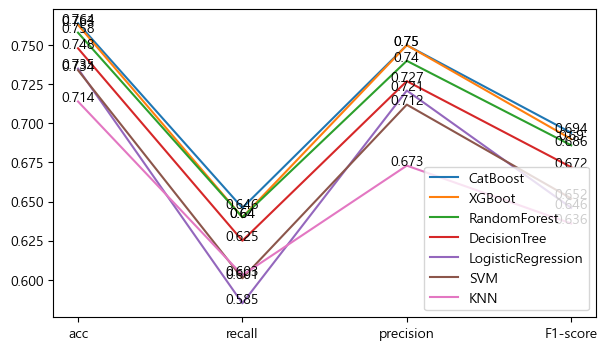

In [42]:
pred_cat = model_cat.predict(x_test)
result_view('CatBoost', pred_cat, y_test)

In [48]:
# model 8 : DNN 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import random

random.seed(10)
np.random.seed(10)
tf.random.set_seed(10)

x_train.shape, y_train.shape #features 개수 확인하기

((41250, 26), (41250,))

In [49]:
# 모델 구성하기
initializer = tf.keras.initializers.GlorotUniform(seed=10) #모델 시드 고정하기
dnn = Sequential()
dnn.add(Dense(8, activation='relu', input_shape=(26,),kernel_initializer=initializer))
dnn.add(Dropout(0.2))
dnn.add(Dense(2, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(1, activation='sigmoid'))

dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237 (948.00 B)

 Trainable params: 237 (948.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 모델 컴파일 – 이진 분류 모델
dnn.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

# Callback : 조기종료, 모델 저장하기
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# val_loss 모니터링해서 성능이 5번 지나도록 좋아지지 않으면 조기 종료하기
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=5)

# val_loss 가장 낮은 값을 가질때마다 모델저장하기
check_point = ModelCheckpoint('best_model.h5', verbose=1, 
                              monitor='val_loss', mode='min', save_best_only=True)

# 모델 학습하기
history = dnn.fit(x=x_train, y=y_train, 
          epochs=50 , batch_size=20,
          validation_data=(x_valid, y_valid), verbose=1,
          callbacks=[early_stop, check_point])

Epoch 1/50
2051/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5931 - loss: 0.6793
Epoch 1: val_loss improved from inf to 0.61708, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5933 - loss: 0.6792 - val_accuracy: 0.6812 - val_loss: 0.6171
Epoch 2/50
2052/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6719 - loss: 0.6251
Epoch 2: val_loss improved from 0.61708 to 0.58371, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6719 - loss: 0.6251 - val_accuracy: 0.7150 - val_loss: 0.5837
Epoch 3/50
2028/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.6833 - loss: 0.6104
Epoch 3: val_loss improved from 0.58371 to 0.57850, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6833 - loss: 0.6104 - val_accuracy: 0.7143 - val_loss: 0.5785
Epoch 4/50
2033/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.6863 - loss: 0.6072
Epoch 4: val_loss improved from 0.57850 to 0.56664, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6863 - loss: 0.6072 - val_accuracy: 0.7236 - val_loss: 0.5666
Epoch 5/50
2006/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6863 - loss: 0.5986
Epoch 5: val_loss improved from 0.56664 to 0.56321, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6863 - loss: 0.5984 - val_accuracy: 0.7265 - val_loss: 0.5632
Epoch 6/50
2045/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.6927 - loss: 0.5883
Epoch 6: val_loss improved from 0.56321 to 0.55840, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6927 - loss: 0.5883 - val_accuracy: 0.7289 - val_loss: 0.5584
Epoch 7/50
2062/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.6955 - loss: 0.5829
Epoch 7: val_loss improved from 0.55840 to 0.55739, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6955 - loss: 0.5829 - val_accuracy: 0.7278 - val_loss: 0.5574
Epoch 8/50
2060/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.6968 - loss: 0.5800
Epoch 8: val_loss improved from 0.55739 to 0.55415, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6968 - loss: 0.5800 - val_accuracy: 0.7289 - val_loss: 0.5541
Epoch 9/50
2029/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6928 - loss: 0.5838
Epoch 9: val_loss did not improve from 0.55415
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6927 - loss: 0.5838 - val_accuracy: 0.7307 - val_loss: 0.5557
Epoch 10/50
2019/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.6928 - loss: 0.5822
Epoch 10: val_loss did not improve from 0.55415
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6927 - loss: 0.5822 - val_accuracy: 0.7300 - val_loss: 0.5542
Epoch 11/50
2025/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6955 - loss: 0.5803
Epoch 11: val_loss improved from 0.55415 to 0.55272, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6954 - loss: 0.5803 - val_accuracy: 0.7307 - val_loss: 0.5527
Epoch 12/50
2045/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6926 - loss: 0.5791
Epoch 12: val_loss improved from 0.55272 to 0.55239, saving model to best_model.h5


2063/2063 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6926 - loss: 0.5791 - val_accuracy: 0.7307 - val_loss: 0.5524
Epoch 13/50
2011/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6967 - loss: 0.5779
Epoch 13: val_loss did not improve from 0.55239
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6967 - loss: 0.5779 - val_accuracy: 0.7276 - val_loss: 0.5539
Epoch 14/50
2028/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6932 - loss: 0.5800
Epoch 14: val_loss did not improve from 0.55239
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6932 - loss: 0.5800 - val_accuracy: 0.7311 - val_loss: 0.5527
Epoch 15/50
2045/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.6934 - loss: 0.5796
Epoch 15: val_loss did not improve from 0.55239
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6934 - loss: 0.5796 - val_accuracy: 0.7303 - val_loss: 0.5545
Epoch 16/50
2028/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6945 - loss: 0.5799
Epoch 16: val_loss

2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6926 - loss: 0.5812 - val_accuracy: 0.7312 - val_loss: 0.5507
Epoch 18/50
2007/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6992 - loss: 0.5759
Epoch 18: val_loss did not improve from 0.55070
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6992 - loss: 0.5759 - val_accuracy: 0.7322 - val_loss: 0.5541
Epoch 19/50
2013/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6985 - loss: 0.5767
Epoch 19: val_loss did not improve from 0.55070
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6984 - loss: 0.5767 - val_accuracy: 0.7322 - val_loss: 0.5510
Epoch 20/50
2057/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6998 - loss: 0.5746
Epoch 20: val_loss did not improve from 0.55070
2063/2063 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6998 - loss: 0.5746 - val_accuracy: 0.7313 - val_loss: 0.5514
Epoch 21/50
2022/2063 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6958 - loss: 0.5770
Epoch 21: val_lo

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step
                      acc  recall  precision  F1-score
CatBoost            0.764   0.646      0.750     0.694
XGBoot              0.763   0.640      0.750     0.690
RandomForest        0.758   0.640      0.740     0.686
DecisionTree        0.748   0.625      0.727     0.672
DNN                 0.740   0.565      0.745     0.643
LogisticRegression  0.735   0.585      0.721     0.646
SVM                 0.734   0.601      0.712     0.652
KNN                 0.714   0.603      0.673     0.636


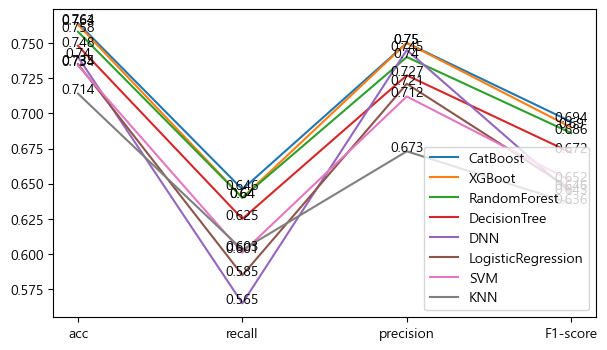

In [53]:
# 결과 예측하기
pred_dnn=(dnn.predict(X_test) > 0.5).astype("int32")        ## 예측값이 0.5 보다 크면 1, 작으면 0 
pred_dnn=pred_dnn.reshape(1,-1)[0]                          ## 예측값을 1차원 리스트화 
result_view('DNN',pred_dnn,y_test)

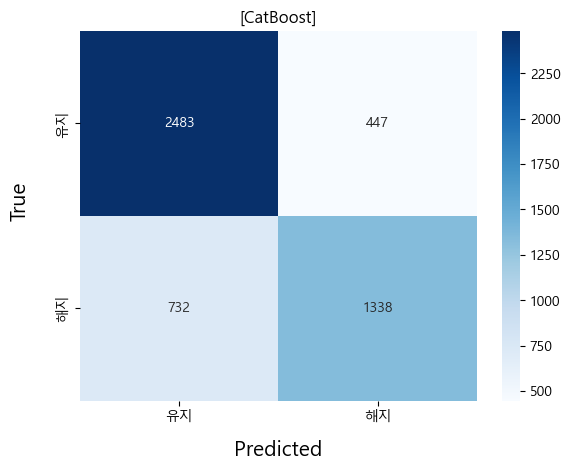

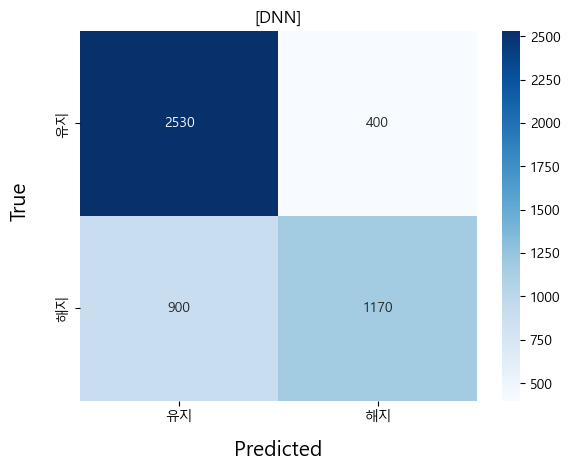

(None, None)

In [55]:
# confusion matrix를 그리기위한 함수를 정의하기
def show_confusion_matrix(labels,y_true,y_pred,title):   
    sns.heatmap(confusion_matrix(y_true,y_pred), annot=True, fmt='d',xticklabels=labels,yticklabels=labels,cmap=plt.cm.Blues,linecolor='black')
    plt.text(1,2.3,'Predicted',size=15,ha='center')
    plt.text(-0.3,1,'True',rotation=90,size=15,ha='center')
    plt.title(title)
    plt.show()
    
labels=['유지','해지']

# 정의된 함수를 활용하여 catboost와 DNN모델의 confusion matrix 그flrl
show_confusion_matrix(labels,y_test,pred_cat,'[CatBoost]'), show_confusion_matrix(labels,y_test,pred_dnn,'[DNN]')

In [59]:
# 패키지 불러오기
from sklearn.metrics import roc_curve, auc

# Parameter
# y_pred: 원핫인코딩된 2차원 이상(class수에 따라)의 numpy.array
# y_true: 실제 값
# y_label: label 값(list)
# ROC를 그려주는 함수

def plot_multiclass_roc(y_pred, y_true, y_label):
    
    # 빈 ditionary 생성하기
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # roc_curve()의 입력값으로 y_true의 가변수 생성하기
    y_true_dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(len(y_label)):
        fpr[i], tpr[i], _ = roc_curve(y_true_dummies[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 각 클래스에 대한 ROC계산하기
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(len(y_label)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y_label[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

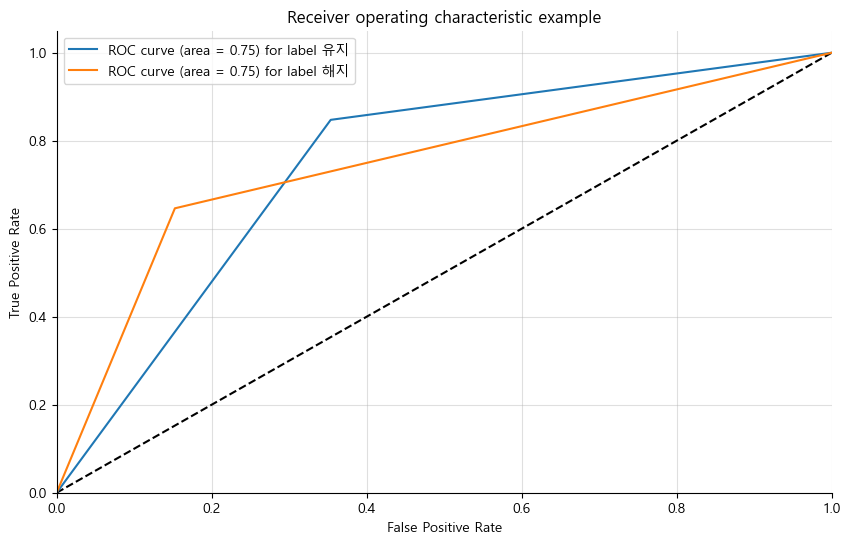

In [60]:
# labels 값은 Confusion Matrix에서 정한 값을 사용하기
plot_multiclass_roc(pd.get_dummies(pred_cat).to_numpy(), y_test, labels)

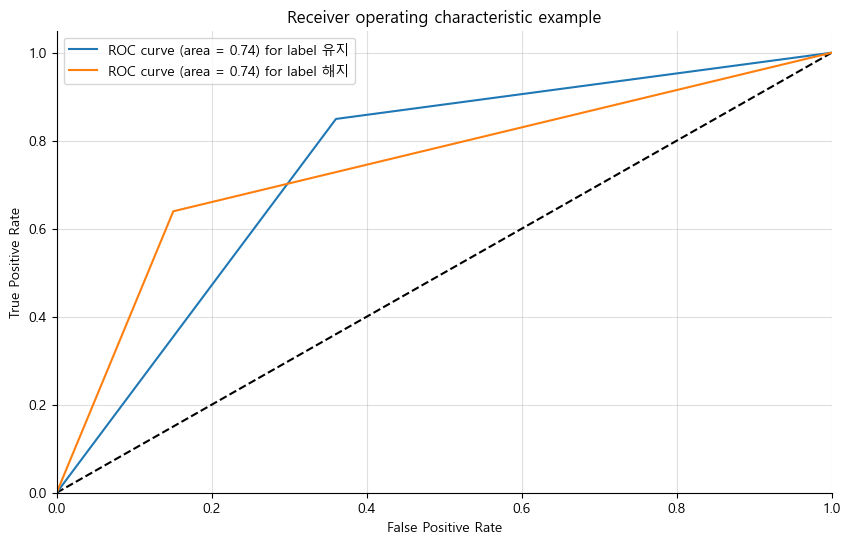

In [61]:
plot_multiclass_roc(pd.get_dummies(pred_xgb).to_numpy(), y_test, labels)

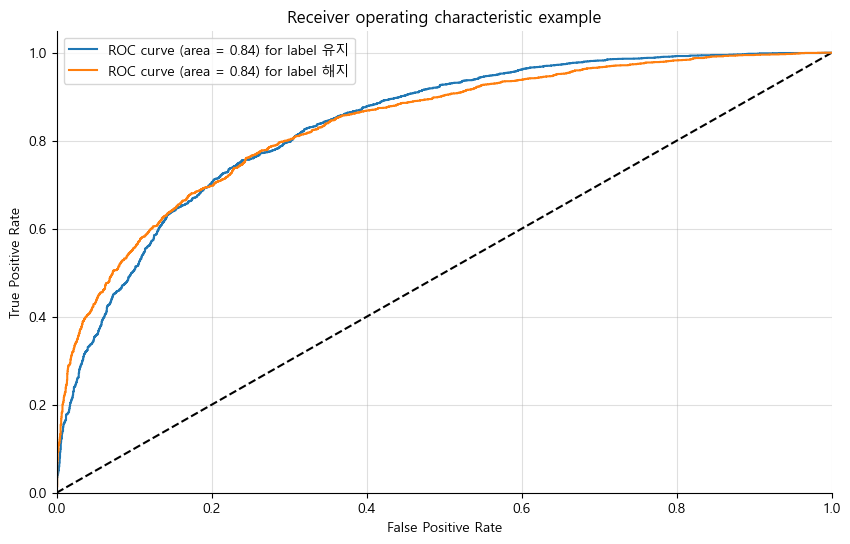

In [64]:
pred_cat_proba=model_cat.predict_proba(x_test)
plot_multiclass_roc(pred_cat_proba, y_test, labels)

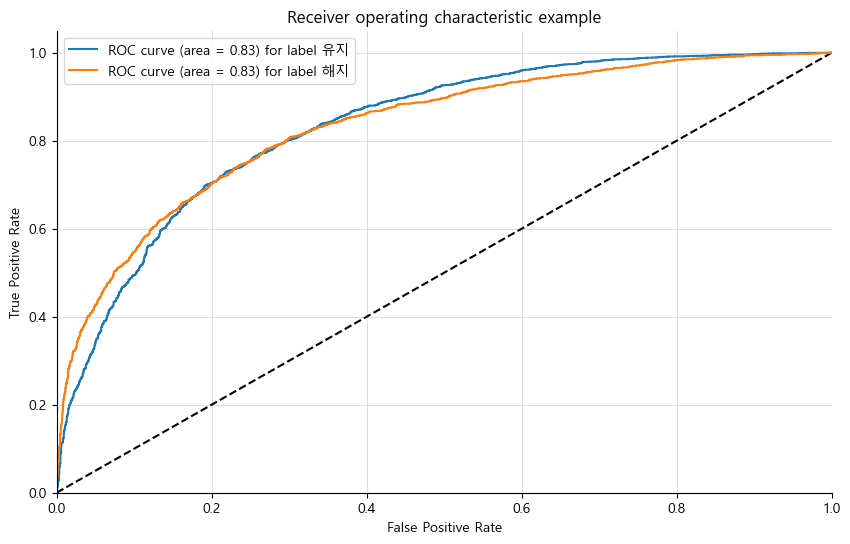

In [63]:
pred_xgb_proba=model_xgb.predict_proba(x_test)
plot_multiclass_roc(pred_xgb_proba, y_test, labels)